[PROTECTED$11$](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/edit-state-human-feedback.ipynb) [PROTECTED$12$](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239520-lesson-3-editing-state-and-human-feedback)



# 编辑图状态（Editing graph state）

## 评审（Review）

We discussed motivations for human-in-the-loop:

我们讨论了引入人工参与的动机：

(1) `Approval` - We can interrupt our agent, surface state to a user, and allow the user to accept an action

`Approval` - 我们可以中断代理，将状态呈现给用户，并允许用户接受某个操作

(2) `Debugging` - We can rewind the graph to reproduce or avoid issues

(2) `Debugging` - 我们可以回退图形以重现或避免问题

(3) `Editing` - You can modify the state 

(3) `Editing` - 您可以修改状态

We showed how breakpoints support user approval, but don't yet know how to modify our graph state once our graph is interrupted!

我们展示了断点如何支持用户确认，但还不知道在图中断后如何修改图的状态！

## 目标（Goals）

Now, let's show how to directly edit the graph state and insert human feedback.

现在，让我们展示如何直接编辑图状态并插入人工反馈。



In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk langgraph-prebuilt

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

## 编辑状态（Editing state）

Previously, we introduced breakpoints.

之前，我们介绍了断点。

We used them to interrupt the graph and await user approval before executing the next node.

我们使用它们来中断图表，并在执行下一个节点之前等待用户批准。

但断点也是[修改图状态的机会](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/edit-graph-state/).
Let's set up our agent with a breakpoint before the `assistant` node.

让我们在 `assistant` 节点之前为代理设置断点。



In [1]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(
    model="qwen-plus-2025-04-28",
    api_key="sk-ba2dda3817f145d7af141fdf32e31d90",
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1"
)
llm_with_tools = llm.bind_tools(tools)

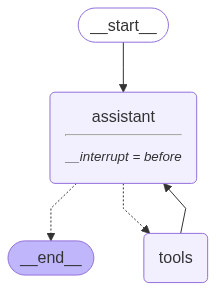

In [2]:
from IPython.display import Image, display 
 
from langgraph.checkpoint.memory import MemorySaver 
from langgraph.graph import MessagesState 
from langgraph.graph import START, StateGraph 
from langgraph.prebuilt import tools_condition, ToolNode 
 
from langchain_core.messages import HumanMessage, SystemMessage 
 
# 系统消息
sys_msg = SystemMessage(content="你是一个乐于助人的助手，负责对一组输入执行算术运算。") 
 
# 节点
def assistant(state: MessagesState): 
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]} 
 
# 图
builder = StateGraph(MessagesState) 
 
# 定义节点：这些节点执行工作
builder.add_node("assistant", assistant) 
builder.add_node("tools", ToolNode(tools)) 
 
# 定义边：这些边决定控制流
builder.add_edge(START, "assistant") 
builder.add_conditional_edges( 
    "assistant", 
    # 如果助手返回的最新消息（结果）是工具调用 -> tools_condition 会路由到 tools
    # 如果助手返回的最新消息（结果）不是工具调用 -> tools_condition 会路由到 END
    tools_condition, 
) 
builder.add_edge("tools", "assistant") 
 
memory = MemorySaver() 
graph = builder.compile(interrupt_before=["assistant"], checkpointer=memory) 
 
# 显示
display(Image(graph.get_graph(xray=True).draw_mermaid_png())) 

Let's run!

让我们运行吧！

We can see the graph is interrupted before the chat model responds. 

我们可以看到，在聊天模型响应之前，图被中断了。



In [6]:
# Input
initial_input = {"messages": "2乘3"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

2乘3


In [7]:
state = graph.get_state(thread)
state

StateSnapshot(values={'messages': [HumanMessage(content='将2和3相乘', additional_kwargs={}, response_metadata={}, id='e7aa5423-9e69-4ee9-8e64-26b3d21a3807'), HumanMessage(content='将2和3相乘', additional_kwargs={}, response_metadata={}, id='45a0d096-09a0-43ed-96e4-68f587f4454c'), HumanMessage(content='将2和3相乘', additional_kwargs={}, response_metadata={}, id='e19583e3-8027-496c-93b9-5c0dc8b4a861'), HumanMessage(content='2乘3', additional_kwargs={}, response_metadata={}, id='b96b82d7-f793-4068-9c91-72a4898e52ab')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f06638a-311b-62f1-8006-d699d1278e71'}}, metadata={'source': 'loop', 'step': 6, 'parents': {}}, created_at='2025-07-21T13:43:08.853315+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f06638a-3118-648f-8005-f5a1818a9d9c'}}, tasks=(PregelTask(id='2f90f2b0-db5d-981a-d318-a3192f420754', name='assistant', path=('__pregel_pull', 'assistant')

Now, we can directly apply a state update.

现在，我们可以直接应用状态更新。

Remember, updates to the `messages` key will use the `add_messages` reducer:
 
* If we want to over-write the existing message, we can supply the message `id`.
* If we simply want to append to our list of messages, then we can pass a message without an `id` specified, as shown below.

记住，对 `messages` 键的更新将使用 `add_messages` reducer：

*如果我们想覆盖现有的消息，可以提供带有 `id` 的消息。* 如果我们只想将消息添加到消息列表中，则可以传递未指定 `id` 的消息，如下所示。



In [8]:
graph.update_state(
    thread,
    {"messages": [HumanMessage(content="不要，实际上要3乘3!")]},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f06638b-775a-6979-8007-174b38ec8a08'}}

Let's have a look.

让我们来看一下。

We called `update_state` with a new message. 

我们用新消息调用了 `update_state`。

The `add_messages` reducer appends it to our state key, `messages`.

`add_messages` 减少器将其附加到我们的状态键 `messages`。



In [9]:
new_state = graph.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

将2和3相乘
================================ Human Message =================================

将2和3相乘
================================ Human Message =================================

将2和3相乘
================================ Human Message =================================

2乘3
================================ Human Message =================================

不要，实际上要3乘3!


Now, let's proceed with our agent, simply by passing `None` and allowing it proceed from the current state.

现在，让我们继续进行我们的代理操作，只需传递 `None` 并允许其从当前状态继续执行。

We emit the current and then proceed to execute the remaining nodes.

我们输出当前内容，然后继续执行剩余的节点。



In [10]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

不要，实际上要3乘3!
================================== Ai Message ==================================
Tool Calls:
  multiply (call_3a405b6d9ce849c7851a6a)
 Call ID: call_3a405b6d9ce849c7851a6a
  Args:
    a: 3
    b: 3
================================= Tool Message =================================
Name: multiply

9


Now, we're back at the `assistant`, which has our `breakpoint`.

现在，我们回到了 `assistant`，它包含了我们的 `breakpoint`。

We can again pass `None` to proceed.

我们可以再次传递 `None` 以继续。



In [11]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

9
================================== Ai Message ==================================

3乘3的结果是9。


### 在 Studio 中编辑图状态（Editing graph state in Studio）

**⚠️ DISCLAIMER**

**⚠️ 免责声明**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

自从这些视频的录制以来，我们已经更新了 Studio，使其可以在本地运行并在浏览器中打开。这是现在运行 Studio 的首选方式（而不是像视频中所示使用桌面应用程序）。请参阅有关 [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) 本地开发服务器的文档和 [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server)。要启动本地开发服务器，请在本模块的 `/studio` 目录中的终端运行以下命令：

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

你应该看到以下输出：  
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the Studio UI: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`.

打开您的浏览器并导航到 Studio UI：`https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`。

The LangGraph API [supports editing graph state](https://langchain-ai.github.io/langgraph/cloud/how-tos/human_in_the_loop_edit_state/#initial-invocation). 

LangGraph API [supports editing graph state](https://langchain-ai.github.io/langgraph/cloud/how-tos/human_in_the_loop_edit_state/#initial-invocation).



In [ ]:
if 'google.colab' in str(get_ipython()):
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab")

In [9]:
# This is the URL of the local development server
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

Our agent is defined in `studio/agent.py`. 

我们的代理定义在 `studio/agent.py`。

If you look at the code, you'll see that it *does not* have a breakpoint! 
 
Of course, we can add it to `agent.py`, but one very nice feature of the API is that we can pass in a breakpoint!

如果你查看代码，你会发现它 *没有* 设置断点！  

当然，我们可以将其添加到 `agent.py`，但该 API 的一个非常有用的功能是，我们可以传入一个断点！

Here, we pass a `interrupt_before=["assistant"]`.

在这里，我们传递一个 `interrupt_before=["assistant"]`.



In [10]:
initial_input = {"messages": "Multiply 2 and 3"}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    "agent",
    input=initial_input,
    stream_mode="values",
    interrupt_before=["assistant"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '882dabe4-b877-4d71-bd09-c34cb97c4f46', 'example': False}
--------------------------------------------------


We can get the current state

我们可以获取当前状态



In [11]:
current_state = await client.threads.get_state(thread['thread_id'])
current_state

{'values': {'messages': [{'content': 'Multiply 2 and 3',
    'additional_kwargs': {},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': '882dabe4-b877-4d71-bd09-c34cb97c4f46',
    'example': False}]},
 'next': ['assistant'],
 'tasks': [{'id': 'a71c0b80-a679-57cb-aa59-a1655b763480',
   'name': 'assistant',
   'error': None,
   'interrupts': [],
   'state': None}],
 'metadata': {'step': 0,
  'run_id': '1ef6a41c-ea63-663f-b3e8-4f001bf0bf53',
  'source': 'loop',
  'writes': None,
  'parents': {},
  'user_id': '',
  'graph_id': 'agent',
  'thread_id': 'a95ffa54-2435-4a47-a9da-e886369ca8ee',
  'created_by': 'system',
  'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca'},
 'created_at': '2024-09-03T22:13:54.466695+00:00',
 'checkpoint_id': '1ef6a41c-ead7-637b-8000-8c6a7b98379e',
 'parent_checkpoint_id': '1ef6a41c-ead3-637d-bfff-397ebdb4f2ea'}

We can look at the last message in state.

我们可以查看状态中的最后一条消息。



In [12]:
last_message = current_state['values']['messages'][-1]
last_message

{'content': 'Multiply 2 and 3',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'human',
 'name': None,
 'id': '882dabe4-b877-4d71-bd09-c34cb97c4f46',
 'example': False}

We can edit it!

我们可以编辑它！



In [13]:
last_message['content'] = "No, actually multiply 3 and 3!"
last_message

{'content': 'No, actually multiply 3 and 3!',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'human',
 'name': None,
 'id': '882dabe4-b877-4d71-bd09-c34cb97c4f46',
 'example': False}

In [14]:
last_message

{'content': 'No, actually multiply 3 and 3!',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'human',
 'name': None,
 'id': '882dabe4-b877-4d71-bd09-c34cb97c4f46',
 'example': False}

Remember, as we said before, updates to the `messages` key will use the same `add_messages` reducer. 

记住，正如我们之前所说，对 `messages` 键的更新将使用相同的 `add_messages` reducer。

If we want to over-write the existing message, then we can supply the message `id`.
Here, we did that. We only modified the message `content`, as shown above.

在这里，我们做到了。我们只修改了消息 `content`，如上所示。



In [15]:
await client.threads.update_state(thread['thread_id'], {"messages": last_message})

{'configurable': {'thread_id': 'a95ffa54-2435-4a47-a9da-e886369ca8ee',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef6a41d-cc8e-6979-8001-8c7c283b636c'},
 'checkpoint_id': '1ef6a41d-cc8e-6979-8001-8c7c283b636c'}

Now, we resume by passing `None`. 

现在，我们通过传递 `None` 继续。



In [16]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="values",
    interrupt_before=["assistant"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': 'No, actually multiply 3 and 3!', 'additional_kwargs': {'additional_kwargs': {}, 'response_metadata': {}, 'example': False}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '882dabe4-b877-4d71-bd09-c34cb97c4f46', 'example': False}
--------------------------------------------------
Receiving new event of type: values...
{'content': '', 'additional_kwargs': {'tool_calls': [{'index': 0, 'id': 'call_vi16je2EIikHuT7Aue2sd1qd', 'function': {'arguments': '{"a":3,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5'}, 'type': 'ai', 'name': None, 'id': 'run-775b42f7-0590-4c54-aaeb-78599b1f12d2', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 3, 'b': 3}, 'id': 'call_vi16je2EIikHuT7Aue2sd1qd', 'type

We get the result of the tool call as `9`, as expected.

我们如预期般获得工具调用的结果为 `9`。



In [17]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="values",
    interrupt_before=["assistant"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': '9', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'multiply', 'id': '226bfbad-0cea-4900-80c5-761a62bd4bc1', 'tool_call_id': 'call_vi16je2EIikHuT7Aue2sd1qd', 'artifact': None, 'status': 'success'}
--------------------------------------------------
Receiving new event of type: values...
{'content': 'The result of multiplying 3 by 3 is 9.', 'additional_kwargs': {}, 'response_metadata': {'finish_reason': 'stop', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5'}, 'type': 'ai', 'name': None, 'id': 'run-859bbf47-9f35-4e71-ae98-9d93ee49d16c', 'example': False, 'tool_calls': [], 'invalid_tool_calls': [], 'usage_metadata': None}
--------------------------------------------------


## 等待用户输入（Awaiting user input）

So, it's clear that we can edit our agent state after a breakpoint.

因此，很明显，我们可以在断点后编辑代理状态。

Now, what if we want to allow for human feedback to perform this state update?

现在，如果我们希望允许人类反馈来执行此状态更新该怎么办？

We'll add a node that [serves as a placeholder for human feedback](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/wait-user-input/#setup) within our agent.

我们将添加一个 [serves as a placeholder for human feedback](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/wait-user-input/#setup) 位于我们代理中的节点。

This `human_feedback` node allow the user to add feedback directly to state.
 
We specify the breakpoint using `interrupt_before` our `human_feedback` node.

此 `human_feedback` 节点允许用户直接向状态添加反馈。

我们使用 `interrupt_before` 我们的 `human_feedback` 节点来指定断点。

We set up a checkpointer to save the state of the graph up until this node.

我们设置了一个检查点，用于保存直到该节点的图状态。



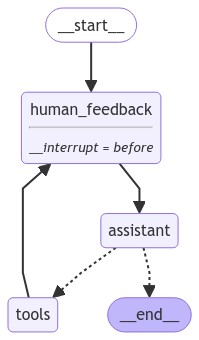

In [18]:
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# no-op node that should be interrupted on
def human_feedback(state: MessagesState):
    pass

# Assistant node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("human_feedback", human_feedback)

# Define edges: these determine the control flow
builder.add_edge(START, "human_feedback")
builder.add_edge("human_feedback", "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "human_feedback")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

We will get feedback from the user.

我们将从用户那里获得反馈。

We use `.update_state` to update the state of the graph with the human response we get, as before.

我们使用 `.update_state` 来根据获得的人类响应更新图的状态，就像之前一样。

We use the `as_node="human_feedback"` parameter to apply this state update as the specified node, `human_feedback`.

我们使用 `as_node="human_feedback"` 参数将此状态更新应用到指定节点 `human_feedback`。



In [19]:
# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id": "5"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()
    
# Get user input
user_input = input("Tell me how you want to update the state: ")

# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"messages": user_input}, as_node="human_feedback")

# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

no, multiply 3 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_sewrDyCrAJBQQecusUoT6OJ6)
 Call ID: call_sewrDyCrAJBQQecusUoT6OJ6
  Args:
    a: 3
    b: 3
================================= Tool Message =================================
Name: multiply

9


In [20]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

9
================================== Ai Message ==================================

The result of multiplying 3 and 3 is 9.
